<h1>Generating Fire Emblem Three Houses like characters using GANs</h1>

First we need modules different modules. Numpy to handle the dataset and mini-batches, Keras to create the neural networks and matplotlib to display results.

In [12]:
from numpy import load, ones, zeros, concatenate
from numpy.random import randint, randn, normal, random

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Reshape, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import RandomNormal

from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [13]:
#The dataset comes from https://www.kaggle.com/barthpaleologue/fire-emblem-three-houses-portraits-complete
def load_dataset(filename):
    dataset = load(filename)
    data = dataset["arr_0"].astype("float32")
    data = (data - 127.5) / 127.5 #map image data from [0,255] to [-1,1]
    return data

# initializing weights from the normal distribution improves the begining of training
init = RandomNormal(mean=0.0, stddev=0.02, seed=None)

def createDiscriminator(input_shape=(128,128,3)):
    dropout = 0.25
    momentum = .8
    alpha = .2
    
    model = Sequential()

    model.add(Conv2D(128, 3, strides=(2,2),input_shape=input_shape, padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout))

    model.add(Conv2D(128, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout))

    model.add(Conv2D(128, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout))

    model.add(Conv2D(256, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(512, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid", kernel_initializer=init))
    
    opt = Adam(lr=.0002, beta_1=.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    model.summary()
    return model

def createGenerator(latent_dim):
    momentum = .9
    alpha = .2
    
    model = Sequential()
    
    model.add(Dense(4*4*256, input_dim=latent_dim, kernel_initializer=init))
    model.add(LeakyReLU(alpha=.2))
    model.add(Reshape([4,4,256]))
    
    model.add(Conv2DTranspose(512, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2DTranspose(256, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
 
    model.add(Conv2DTranspose(128, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2DTranspose(128, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2DTranspose(128, 3, strides=(2,2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization(momentum=momentum))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(3, 5, padding="same", activation="tanh", kernel_initializer=init))
    model.summary()
    return model

def createGan(g_model, d_model):
    d_model.trainable = False #the discriminator is not trainable here.
    
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    
    opt = Adam(lr=.0002, beta_1=.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    model.summary()
    return model

def generate_latent_points(latent_dim, nbpoints):
    random_points = randn(latent_dim * nbpoints)
    random_points = random_points.reshape((nbpoints, latent_dim))
    return random_points

def getRealSamples(dataset, nb_samples):
    random_indexes = randint(0, dataset.shape[0], nb_samples)
    samples = dataset[random_indexes]
    labels = ones((nb_samples, 1)) - 0.1
    
    return samples, labels

def getFakeSamples(g_model, latent_dim, nb_samples):
    latent_inputs = generate_latent_points(latent_dim, nb_samples)
    samples = g_model.predict(latent_inputs)
    labels = zeros((nb_samples,1))
    
    return samples, labels

In [14]:
D_loss = []
G_loss = []

def train(g_model, d_model, gan_model, dataset, iterations, batch_size, latent_dim):
    for i in range(iterations):
        d_model.trainable = True
        x_real, y_real = getRealSamples(dataset, batch_size)
        x_fake, y_fake = getFakeSamples(g_model, latent_dim, batch_size)

        d_loss1 = d_model.train_on_batch(x_real, y_real)
        d_loss2 = d_model.train_on_batch(x_fake, y_fake)
        D_loss.append((d_loss1+d_loss2) / 2)

        d_model.trainable = False
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = ones((batch_size,1))

        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        G_loss.append(g_loss)

        print(f"Iteration {i}", end="\r")
        if i%500==0:
            d_model.save(f"checkpoints/discri_{i}.h5")
            g_model.save(f"checkpoints/gene_{i}.h5")

        if i%100==0:
            g_model.save("checkpoints/onthefly.h5")
            fakedemo = getFakeSamples(g_model, latent_dim, 9)
            plt.figure()
            for j in range(9):
                plt.subplot(3,3,j+1)
                plt.axis("off")
                plt.imshow((fakedemo[0][j]+1)/2)
            if i%500 == 0: 
                plt.savefig(f"resultat{i}.png")
            plt.show()
            plt.figure()
            plt.plot(D_loss[-1000:])
            plt.plot(G_loss[-1000:])
            plt.show()

Dataset Importation

In [8]:
dataset = load_dataset(filename="dataset128.npz")
print(dataset.shape)

(10560, 128, 128, 3)


A few global settings

In [4]:
latent_dim = 128
iterations = 50000
batch_size = 64

Creating/Loading the discriminator

In [15]:
d_model = load_model("checkpoints/discri_9000.h5")
#d_model = createDiscriminator()

Creating/Loading the generator

In [16]:
g_model = load_model("checkpoints/gene_9000.h5")
#g_model = createGenerator(latent_dim)

Associate both to create the GAN

In [17]:
gan_model = createGan(g_model, d_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 128, 128, 3)       3492867   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1786881   
Total params: 5,279,748
Trainable params: 3,490,563
Non-trainable params: 1,789,185
_________________________________________________________________


Training time !!!

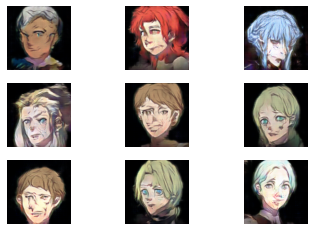

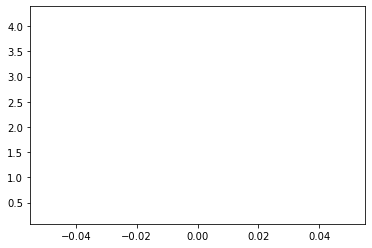

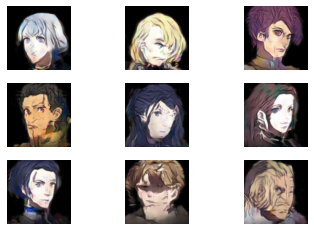

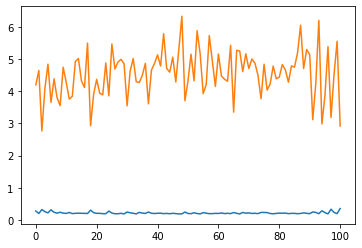

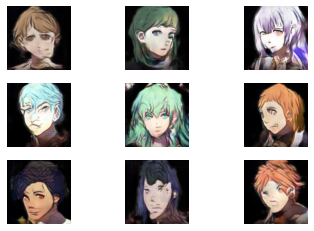

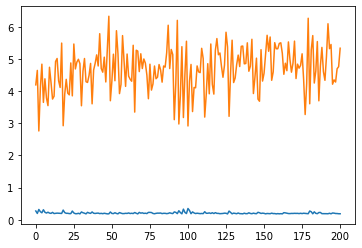

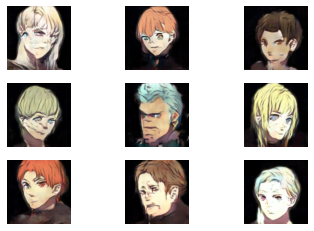

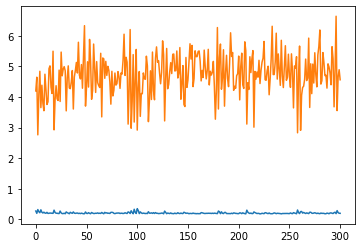

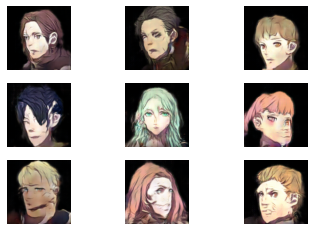

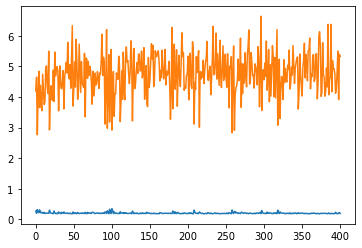

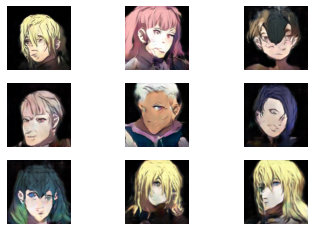

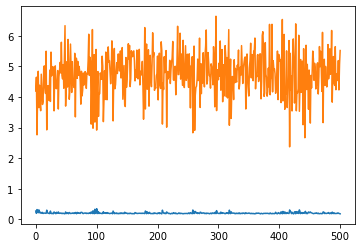

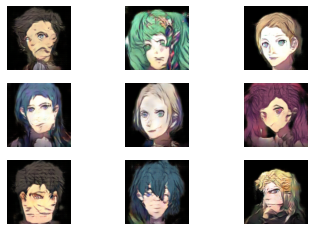

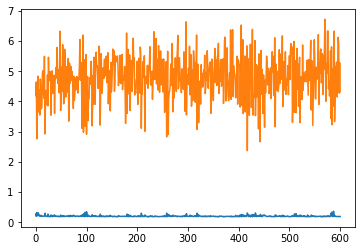

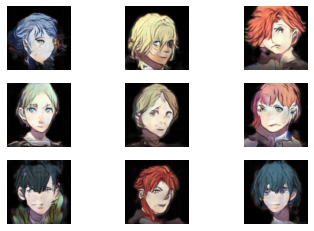

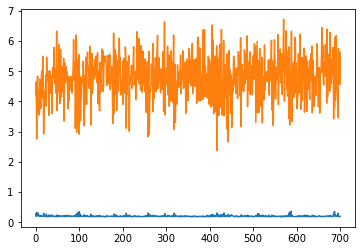

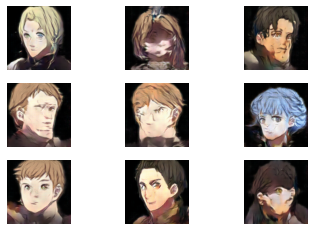

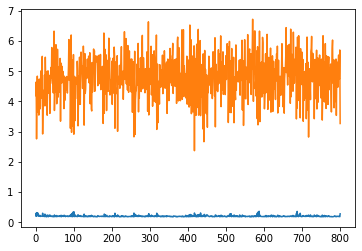

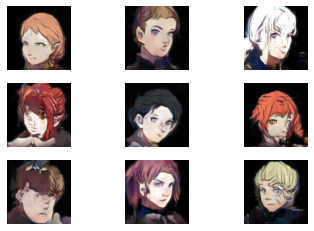

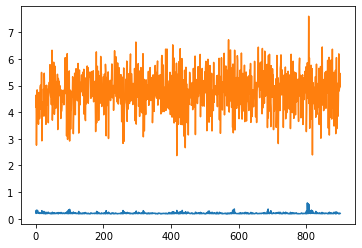

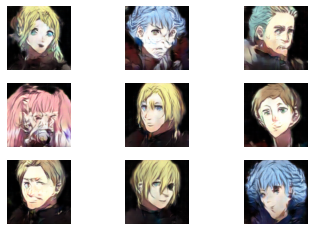

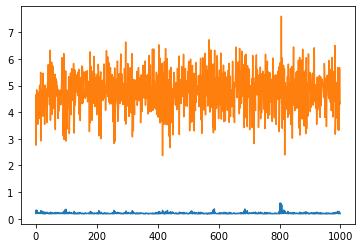

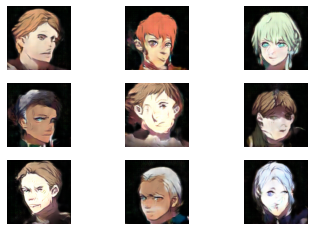

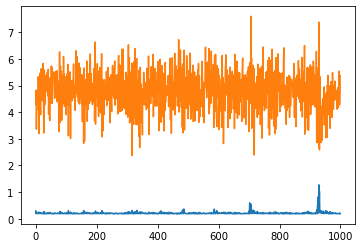

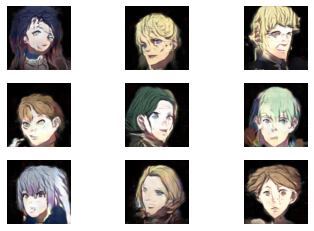

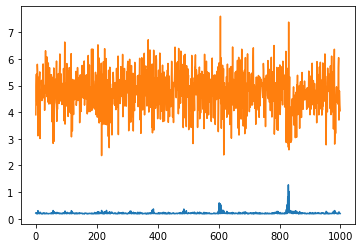

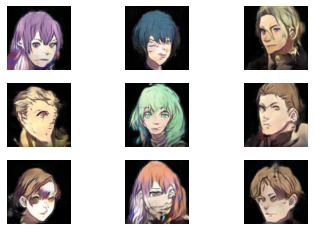

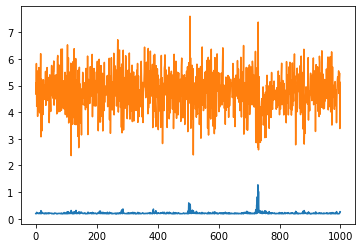

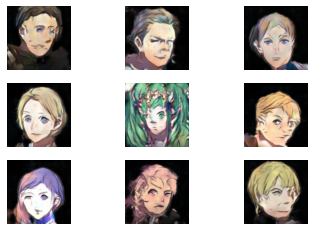

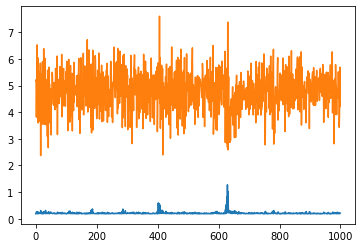

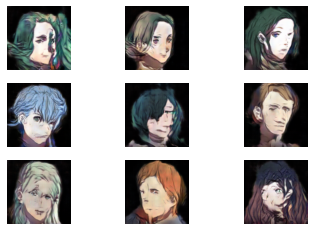

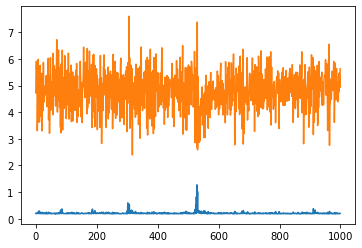

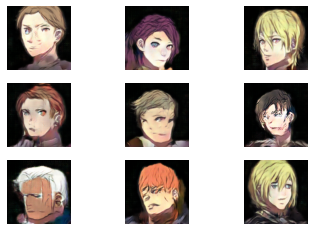

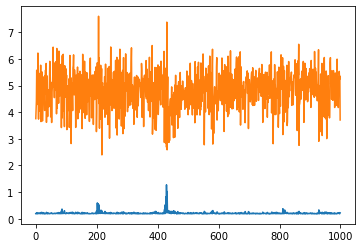

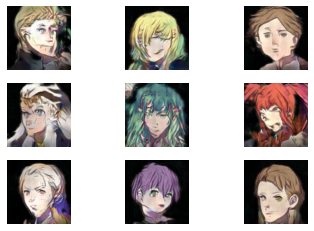

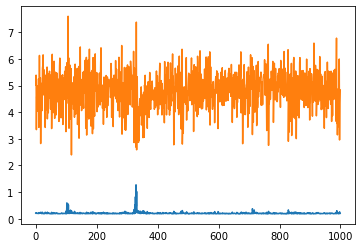

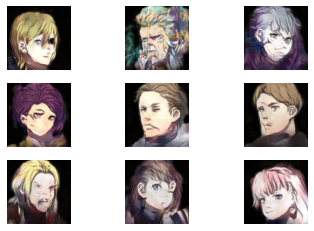

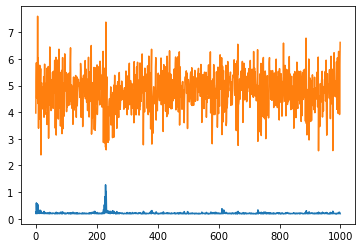

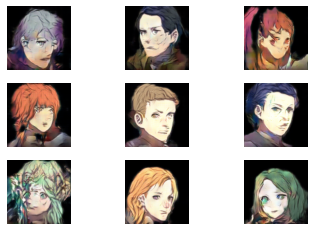

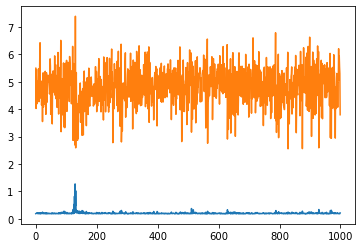

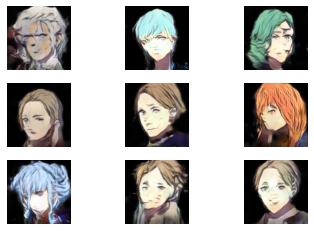

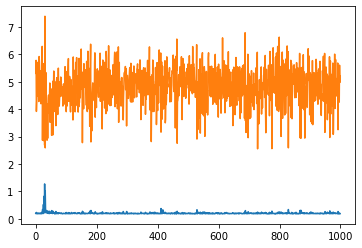

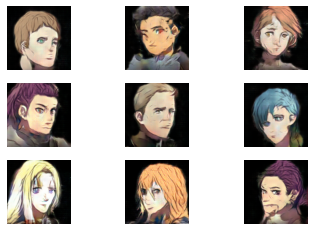

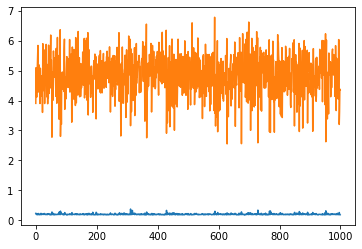

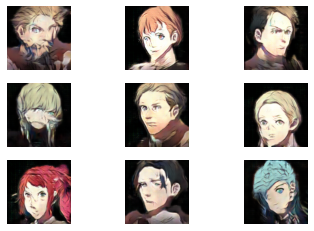

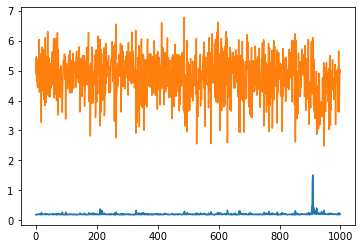

KeyboardInterrupt: 

In [18]:
train(g_model, d_model, gan_model, dataset, iterations, batch_size, latent_dim)

Display losses evolutions

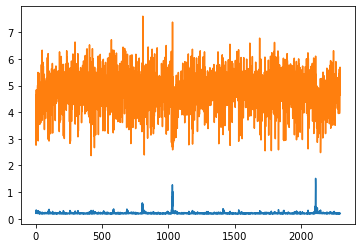

In [19]:
plt.figure()
plt.plot(D_loss)
plt.plot(G_loss)
plt.show()

Generate 100 images stored in the res folder as a demo

In [20]:
from PIL import Image as Img

demonstration, _ = getFakeSamples(g_model, latent_dim, 100)
for i,face in enumerate(demonstration):
    face = ((face+1)*127.5).astype("uint8")
    Img.fromarray(face).save(f"res/face{i}.png")